# Input data checking and visualization

In [1]:
# general tools
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
from scipy.ndimage import gaussian_filter

# graph tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cmaps
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset, InsetPosition
%matplotlib inline

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/')
from namelist import *

sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/utils/')
import QC_utils as qu

sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
import data_utils as du
import graph_utils as gu


In [3]:
import importlib
importlib.reload(du)

<module 'data_utils' from '/glade/u/home/ksha/WORKSPACE/utils/data_utils.py'>

In [4]:
JET = []
JET.append(gu.xcolor('indian red'))
JET.append(gu.xcolor('gold'))
JET.append(gu.xcolor('dark sea green'))
JET.append(gu.xcolor('deep sky blue'))
JET.append(gu.xcolor('royal blue'))

JET = JET[::-1]

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [6]:
fig_dir = '/glade/u/home/ksha/figures/'

In [7]:
import cmaps

# Checking regridded CaPA data

**Station metadata**

In [8]:
with pd.HDFStore(BCH_meta_file, 'r') as hdf_temp:
    metadata = hdf_temp['metadata']
    stn_lon = metadata['lon'][:].values
    stn_lat = metadata['lat'][:].values
    stn_code = metadata['code'][:].values

**CaPA lat/lon**

In [9]:
# re-gridded version
with h5py.File(GRID_INPUT_file, 'r') as hdf_io:
    #
    xgrid1, ygrid1 = hdf_io['xgrid1'][...], hdf_io['ygrid1'][...]
    xgrid2, ygrid2 = hdf_io['xgrid2'][...], hdf_io['ygrid2'][...]
    xgrid3, ygrid3 = hdf_io['xgrid3'][...], hdf_io['ygrid3'][...]
    xgrid4, ygrid4 = hdf_io['xgrid4'][...], hdf_io['ygrid4'][...]
    xgrid5, ygrid5 = hdf_io['xgrid5'][...], hdf_io['ygrid5'][...]
    #
    capa1, etopo1 = hdf_io['capa1'][...], hdf_io['etopo1'][...]
    capa2, etopo2 = hdf_io['capa2'][...], hdf_io['etopo2'][...]
    capa3, etopo3 = hdf_io['capa3'][...], hdf_io['etopo3'][...]
    capa4, etopo4 = hdf_io['capa4'][...], hdf_io['etopo4'][...]
    capa5, etopo5 = hdf_io['capa5'][...], hdf_io['etopo5'][...]

In [10]:
# original version
with h5py.File(BACKUP_dir+'CaPA_compressed_BC.hdf', 'r') as hdf_io:
    capa_lon = hdf_io['lon'][...]
    capa_lat = hdf_io['lat'][...]


**Inspect grid spacings as km**

In [11]:
def get_dist_xy(dist_lon, dist_lat, print_out=True):
    distx = dist_lon[:, 1]-dist_lon[:, 0]
    disty = dist_lat[1, :]-dist_lat[0, :]
    if print_out:
        print('Mean distance: x,y = ({}, {}) km, '.format(np.max(distx)/1e3, np.max(disty)/1e3))
    return np.max(distx)/1e3, np.max(disty)/1e3

xgrid = (xgrid1, xgrid2, xgrid3, xgrid4, xgrid5, capa_lon) # xgrid6
ygrid = (ygrid1, ygrid2, ygrid3, ygrid4, ygrid5, capa_lat)
dict_distx = {}; dict_disty = {}
for i in range(len(xgrid)):
    dict_distx[str(i)], dict_disty[str(i)] = du.latlon_to_dist(xgrid[i], ygrid[i], refp_lon='self', refp_lat='self')
# dict to tuple
distx = tuple(dict_distx.values()); disty = tuple(dict_disty.values())

mean_dist = {}
for i in range(len(xgrid)):
    mean_dist[str(i)] = get_dist_xy(distx[i], disty[i]);
mean_dist = tuple(mean_dist.values())

Mean distance: x,y = (38.65713515039705, 37.06502790806397) km, 
Mean distance: x,y = (30.925718545342047, 29.536194114238175) km, 
Mean distance: x,y = (23.160235842846138, 22.108964015336213) km, 
Mean distance: x,y = (15.41752058745095, 14.65361568458261) km, 
Mean distance: x,y = (9.223464952840796, 8.771769945759349) km, 
Mean distance: x,y = (9.662950411862417, 8.663325609277763) km, 


# Domain figure

In [12]:
time_ind = 10

In [13]:
with h5py.File(BACKUP_dir+'CaPA_compressed_BC.hdf', 'r') as hdf_io:
    CaPA = hdf_io['CaPA'][time_ind, ...]/6.0 # per hour
    capa_lon = hdf_io['lon'][...]
    capa_lat = hdf_io['lat'][...]
    
indx_ori, indy_ori = du.grid_search(capa_lon, capa_lat, stn_lon, stn_lat)
stn_grid = CaPA[indx_ori, indy_ori]

In [14]:
stn_obs_raw = []
stn_obs_qc = []

stn_flag = []
with pd.HDFStore(BACKUP_dir+'BCH_30min.hdf', 'r') as hdf_temp:
    for code in stn_code:
        try:
            val = hdf_temp[code]['PREC_INST_RAW'][12*(time_ind-1)+1]
            stn_obs_raw.append(2.0*val)
            val = hdf_temp[code]['PREC_INST_QC'][12*(time_ind-1)+1]
            stn_obs_qc.append(2.0*val)
            
            stn_flag.append(True)
        except:
            stn_flag.append(False)
            
stn_obs_raw = np.array(stn_obs_raw)
flag_nz = stn_obs_raw>0
flag_3 = np.logical_and(stn_obs_raw>0, stn_obs_raw<3)

In [17]:
cmap_pct = plt.cm.gist_ncar_r

In [18]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# BC and Ca-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

shape_dir = fig_dir+'wshed_hires/MajorHydroWatershedsProject.shp'

In [19]:
inds_x = {}; inds_y = {}; EDGE_x = {}; EDGE_y = {}
N_stn = len(stn_code)
for i in range(len(xgrid)):
    inds_x[str(i)], inds_y[str(i)] = du.grid_search(xgrid[i], ygrid[i], stn_lon, stn_lat)
    EDGE_x[str(i)] = np.vstack([
        xgrid[i][inds_x[str(i)]-half_edge[0], inds_y[str(i)]-half_edge[0]],
        xgrid[i][inds_x[str(i)]-half_edge[0], inds_y[str(i)]+half_edge[0]],
        xgrid[i][inds_x[str(i)]+half_edge[0], inds_y[str(i)]+half_edge[0]],
        xgrid[i][inds_x[str(i)]+half_edge[0], inds_y[str(i)]-half_edge[0]]
    ])
    EDGE_y[str(i)] = np.vstack([
        ygrid[i][inds_x[str(i)]-half_edge[1], inds_y[str(i)]-half_edge[1]],
        ygrid[i][inds_x[str(i)]-half_edge[1], inds_y[str(i)]+half_edge[1]],
        ygrid[i][inds_x[str(i)]+half_edge[1], inds_y[str(i)]+half_edge[1]],
        ygrid[i][inds_x[str(i)]+half_edge[1], inds_y[str(i)]-half_edge[1]]
    ])
    
inds_x = tuple(inds_x.values()); inds_y = tuple(inds_y.values())
EDGE_x = tuple(EDGE_x.values()); EDGE_y = tuple(EDGE_y.values())

In [20]:
# generate lat/lon for the "box"
stn_ind = 87
edge1 = [np.min(EDGE_x[0][:, stn_ind])+1.5, np.max(EDGE_x[0][:, stn_ind])-4, 
        np.min(EDGE_y[0][:, stn_ind])+1.5, np.max(EDGE_y[0][:, stn_ind])-1.5]
stn_ind = 87
edge2 = [np.min(EDGE_x[0][:, stn_ind])-2.5, np.max(EDGE_x[0][:, stn_ind])+2.5, 
       np.min(EDGE_y[0][:, stn_ind])-2.5, np.max(EDGE_y[0][:, stn_ind])+2.5]

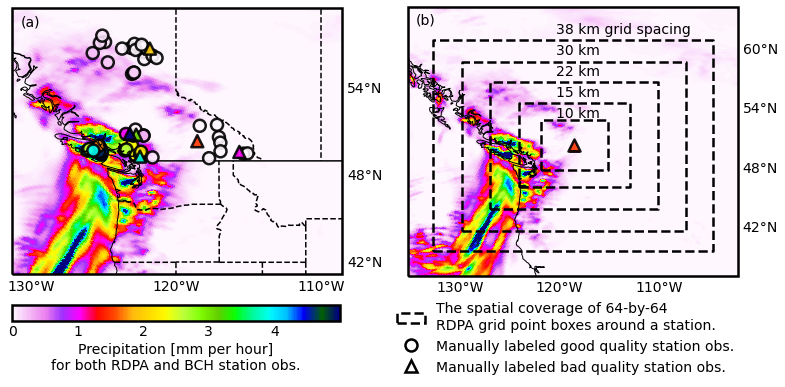

In [25]:
labels = ['10 km', '15 km', '22 km', '30 km', '38 km grid spacing'][::-1]
# ----- #
vmin = 0
vmax = 4.999

fig = plt.figure(figsize=(13, 6))
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
AX = [ax1, ax2]

# ===== #
for i, ax in enumerate(AX):
    if i == 0:
        edge = edge1
    else:
        edge = edge2
        
    ax.set_extent(edge, ccrs.Geodetic())
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor=cmap_pct(0))
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=4)
    if i == 0:
        ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=1.5, zorder=3)
        ax.add_feature(PROVINCE, edgecolor='k', linestyle='--', linewidth=1.5, zorder=3)
    ax.spines['geo'].set_linewidth(2.5)
    
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
    GL.top_labels = False
    GL.left_labels = False
    GL.xformatter = LONGITUDE_FORMATTER
    GL.yformatter = LATITUDE_FORMATTER
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.xlocator = mticker.FixedLocator([-140, -130, -120, -110, -100])
    GL.ylocator = mticker.FixedLocator([36, 42, 48, 54, 60])

CS = ax1.pcolormesh(capa_lon, capa_lat, CaPA, vmin=vmin, vmax=vmax, cmap=cmap_pct)
ax1.scatter(stn_lon[stn_flag][~flag_nz], stn_lat[stn_flag][~flag_nz], c=stn_obs_raw[~flag_nz], s=12*12, 
            edgecolor='k', linewidth=2.5, zorder=4, vmin=vmin, vmax=vmax, cmap=cmap_pct, alpha=0.9)
ax1.scatter(stn_lon[stn_flag][flag_nz], stn_lat[stn_flag][flag_nz], c=stn_obs_raw[flag_nz], marker='^', s=12*12, 
            edgecolor='k', linewidth=2.5, zorder=5, vmin=vmin, vmax=vmax, cmap=cmap_pct, alpha=0.9)

handle_text = ax1.text(0.025, 0.975, '(a)', ha='left', va='top', fontsize=14, transform=ax1.transAxes, zorder=6)
handle_text.set_bbox(dict(facecolor='none', edgecolor='none', zorder=6))

handle_text = ax2.text(0.025, 0.975, '(b)', ha='left', va='top', fontsize=14, transform=ax2.transAxes, zorder=6)
handle_text.set_bbox(dict(facecolor='none', edgecolor='none', zorder=6))

boxes = []; legend_box = []
ax2.pcolormesh(capa_lon, capa_lat, CaPA, vmin=vmin, vmax=vmax, cmap=cmap_pct)

ax2.scatter(stn_lon[stn_flag][flag_nz][4], stn_lat[stn_flag][flag_nz][4], c=stn_obs_raw[flag_nz][4], marker='^', s=12*12, 
            edgecolor='k', linewidth=2.5, zorder=5, vmin=vmin, vmax=vmax, cmap=cmap_pct, alpha=0.9)

for i in range(5):
    points = np.array([[EDGE_x[i][0, stn_ind], EDGE_y[i][0, stn_ind]],
                       [EDGE_x[i][1, stn_ind], EDGE_y[i][1, stn_ind]],
                       [EDGE_x[i][2, stn_ind], EDGE_y[i][2, stn_ind]],
                       [EDGE_x[i][3, stn_ind], EDGE_y[i][3, stn_ind]]])
    
    boxes = PatchCollection([patches.Polygon(points)], facecolor='none', edgecolor='k', linewidth=2.5, linestyle='--', zorder=5)
    ax2.add_collection(boxes)

legend_box.append(
    patches.Patch(
        facecolor='none', edgecolor='k', linewidth=2.5, linestyle='--',
        label='The spatial coverage of 64-by-64\nRDPA grid point boxes around a station.'))

legend_box.append(mlines.Line2D([], [], color='w', marker='o', ms=12, mec='k', mew=2.5, 
                                label='Manually labeled good quality station obs.'))
legend_box.append(mlines.Line2D([], [], color='w', marker='^', ms=12, mec='k', mew=2.5, 
                                label='Manually labeled bad quality station obs.'))

y0 = 0.9; dy = 0.0775
for l, label in enumerate(labels):
    ax2.text(0.45, y0-l*dy, label, fontsize=14, transform=ax2.transAxes)

ax_lg = fig.add_axes([0.545, -0.04, 0.365, 0.2])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_box, bbox_to_anchor=(1, 1), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

ax_base = fig.add_axes([0.125, 0.0, 0.35, 0.125])
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='30%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('Precipitation [mm per hour]\nfor both RDPA and BCH station obs.', fontsize=14)
CBar.outline.set_linewidth(2.5)

fig.savefig(fig_dir+'QC_grid_spacing_revised.png', dpi=250, orientation='portrait', \
           papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

# Domain figure (old)

/glade/work/ksha/py_env_20200417/lib/python3.6/site-packages/ipykernel_launcher.py:57: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
/glade/work/ksha/py_env_20200417/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:305: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/ksha/py_env_20200417/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:329: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/glade/work/ksha/py_env_20200417/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


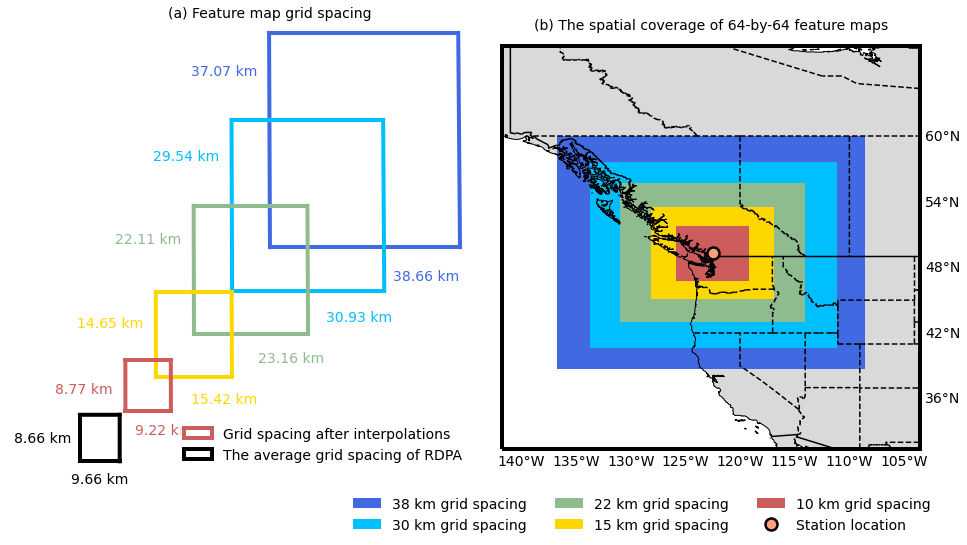

In [16]:
# stn_ind = 14
# topo_level=np.arange(0, 3200, 200)
# labels = ['10 km', '15 km', '22 km', '30 km', '38 km']
# # ----- #

# fig = plt.figure(figsize=(13, 7))
# ax1 = plt.subplot(1, 2, 1)
# ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
# # ===== #
# ax = ax1
# ax = gu.ax_decorate(ax, False, False)
# ax.spines["left"].set_visible(False)
# ax.grid(False)
# #ax.autoscale(enable=True, tight=True)
# #ax.set_xlabel('Zonal distance [m]', fontsize=14)
# #ax.set_ylabel('Meridional distance [m]', fontsize=14)

# for i in range(len(xgrid)-1):
#     # -1 for excluding capa original grids
#     ax.plot(distx[i][1:3, 1:3], disty[i][1:3, 1:3], color=JET[i], lw=4, ls='-',);
#     ax.plot(distx[i][1:3, 1:3].T, disty[i][1:3, 1:3].T, color=JET[i], lw=4, ls='-',);
#     # text
#     ax.text(1.65*distx[i][1, 1]-1e3*i, disty[i][1, 1]-5e3+4e2*i, '{0:0.2f} km'.format(mean_dist[i][0]), ha='left', va='center', color=JET[i], fontsize=14)
#     ax.text(distx[i][1, 1]-2.5e3, disty[i][2, 1]-5e3-4e2*(ens-1-i), '{0:0.2f} km'.format(mean_dist[i][1]), ha='right', va='center', color=JET[i], fontsize=14)
    

# ax.plot(distx[-1][:2, :2], disty[-1][:2, :2], color='k', lw=4, ls='-', zorder=4);
# ax.plot(distx[-1][:2, :2].T, disty[-1][:2, :2].T, color='k', lw=4, ls='-', zorder=4);

# ax.text(0.5*distx[-1][1, 1], 0.25*disty[-1][1, 1]-5e3, '{0:0.2f} km'.format(mean_dist[-1][0]), ha='center', va='center', color='k', fontsize=14)
# ax.text(-7.5e3, 0.25*disty[-1][2, 1], '{0:0.2f} km'.format(mean_dist[-1][1]), ha='center', va='center', color='k', fontsize=14)

# ax.set_title('(a) Feature map grid spacing', fontsize=14, y=0.975)

# legend_roc = [] 
# legend_roc.append(patches.Patch(facecolor='w', edgecolor=JET[i], linewidth=4, label='Grid spacing after interpolations'))
# legend_roc.append(patches.Patch(facecolor='w', edgecolor='k', linewidth=4, label='The average grid spacing of RDPA'))

# ax_lg = fig.add_axes([0, 0.065, 0.5, 0.1])
# ax_lg.set_axis_off()
# LG = ax_lg.legend(handles=legend_roc, bbox_to_anchor=(1, 1), ncol=1, prop={'size':14});
# LG.get_frame().set_facecolor('white')
# LG.get_frame().set_edgecolor('k')
# LG.get_frame().set_linewidth(0)

# # ===== #
# ax = ax2
# ax.set_title('(b) The spatial coverage of 64-by-64 feature maps', fontsize=14, y=1.025)
# edge = [np.min(EDGE_x[0][:, stn_ind])-5, np.max(EDGE_x[0][:, stn_ind])+5, np.min(EDGE_y[0][:, stn_ind])-7.25, np.max(EDGE_y[0][:, stn_ind])+7.25]
# ax.set_extent(edge, ccrs.Geodetic())
# ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.85')
# ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=4)
# ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=1.5, zorder=4)
# ax.add_feature(PROVINCE, edgecolor='k', linestyle='--', linewidth=1.5, zorder=4)
# #ax.add_feature(cfeature.LAKES.with_scale(scale_param), linewidth=0, facecolor='k', zorder=5)
# #ax.add_feature(cfeature.RIVERS.with_scale(scale_param), linewidth=0.5, edgecolor='k', zorder=5)
# ax.outline_patch.set_linewidth(4)
# # ax.add_geometries(Reader(shape_dir).geometries(), ccrs.PlateCarree(),
# #                   facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='///')

# GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
# GL.xlabels_top = False
# GL.ylabels_left = False
# GL.xformatter = LONGITUDE_FORMATTER
# GL.yformatter = LATITUDE_FORMATTER
# GL.xlabel_style = {'size': 14}
# GL.ylabel_style = {'size': 14}
# GL.ylocator = mticker.FixedLocator([36, 42, 48, 54, 60])
# #GL.xlocator = mticker.FixedLocator([-126, -124, -122, -120, -118, -116])
# #CS = ax.contourf(nav_lon[::s, ::s], nav_lat[::s, ::s], CDEM[::s, ::s], topo_level, cmap=plt.cm.terrain, extend='max')

# boxes = []; hatches = ['/', '\\', '/', '\\', '/']; legend_box = []
# for i in range(len(xgrid)-1):
#     points = np.array([[EDGE_x[i][0, stn_ind], EDGE_y[i][0, stn_ind]],
#                        [EDGE_x[i][1, stn_ind], EDGE_y[i][1, stn_ind]],
#                        [EDGE_x[i][2, stn_ind], EDGE_y[i][2, stn_ind]],
#                        [EDGE_x[i][3, stn_ind], EDGE_y[i][3, stn_ind]]])
#     boxes = PatchCollection([patches.Polygon(points)], facecolor=JET[i], edgecolor='none', linewidth=0, zorder=i)
    
#     legend_box.append(patches.Patch(facecolor=JET[i], edgecolor='none', linewidth=0, label='{} grid spacing'.format(labels[::-1][i])))
    
#     ax.add_collection(boxes)
# Handle = ax.plot(stn_lon[stn_ind], stn_lat[stn_ind], 'ro', ms=12, mfc=gu.xcolor('light salmon'), mec='k', mew=2.5, zorder=5, label='Station location')

# ax_lg = fig.add_axes([0.5, -0.075, 0.5, 0.1])
# ax_lg.set_axis_off()
# LG = ax_lg.legend(handles=legend_box+Handle, bbox_to_anchor=(1, 1), ncol=3, prop={'size':14});
# LG.get_frame().set_facecolor('white')
# LG.get_frame().set_edgecolor('k')
# LG.get_frame().set_linewidth(0)
# plt.tight_layout()

# # fig.savefig(fig_dir+'QC_grid_spacing.png', dpi=250, orientation='portrait', \
# #            papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

# Generate and save 64-by-64 sized croppings for each station

In [16]:
# all stations
with pd.HDFStore(BCH_meta_file, 'r') as hdf_temp:
    metadata = hdf_temp['metadata']
    stn_lon = metadata['lon'][:].values
    stn_lat = metadata['lat'][:].values
    stn_code = metadata['code'][:].values

In [18]:
grid_stn = {}
for i, code in enumerate(stn_code):
    DATA = np.empty([ens*2, half_edge[0]*2, half_edge[1]*2])
    for j in range(ens):
        temp_indx = inds_x[j][i]
        temp_indy = inds_y[j][i]

        temp_xgrid = xgrid[j][temp_indx-half_edge[0]:temp_indx+half_edge[0], temp_indy-half_edge[1]:temp_indy+half_edge[1]]
        temp_ygrid = ygrid[j][temp_indx-half_edge[0]:temp_indx+half_edge[0], temp_indy-half_edge[1]:temp_indy+half_edge[1]]
        DATA[2*j, ...] = temp_xgrid
        DATA[2*j+1, ...] = temp_ygrid

    grid_stn[code] = DATA

In [19]:
np.save('/glade/scratch/ksha/BACKUP/station_latlon_64.npy', grid_stn)

## ETOPO data checking

In [42]:
# ETOPO_path = '/Users/yingkai/Repository/WRFT/_data/Reanalysis/ETOPO/etopo5.nc'

# with nc.Dataset(ETOPO_path) as nc_obj:
#     etopo_x = nc_obj.variables['topo_lon'][...]
#     etopo_y = nc_obj.variables['topo_lat'][...]
#     etopo_z = nc_obj.variables['topo'][...]
    
# etopo_lon, etopo_lat = np.meshgrid(etopo_x, etopo_y)

# Visual inspections of raw and human QC'd values

In [79]:
# kill pandas warning
import warnings
warnings.filterwarnings("ignore")
# pd.HDFStore does not support multiple access, must inside a with scope
with pd.HDFStore(BACKUP_dir+'BCH_half_hourly.hdf', 'r') as hdf_temp:
    temp_pd = hdf_temp['ALU']
    
temp_pd = temp_pd.set_index(temp_pd['datetime'])
temp_pd = temp_pd.resample('1800S', how='mean')
temp_pd = temp_pd.reset_index()

Text(0.5,1,'(b) ALU, var: PREC_INST_QC, freq: 30-min')

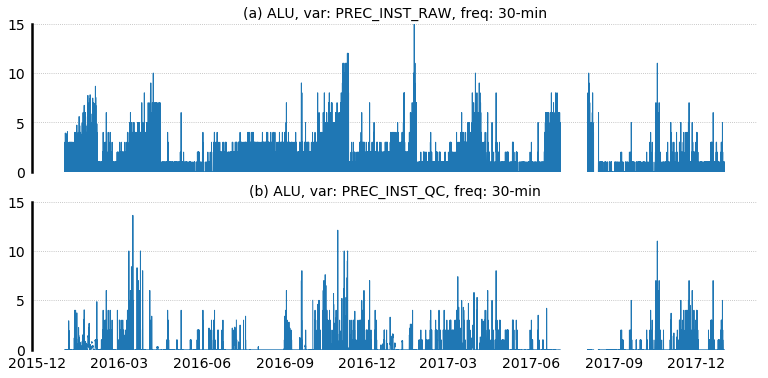

In [80]:
fig = plt.figure(figsize=(13, 6))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)
ax1.set_ylim([0, 15])
ax2.set_ylim([0, 15])
ax1 = gu.ax_decorate(ax1, True, False)
ax2 = gu.ax_decorate(ax2, True, True)
#ax1.set_ylabel('Precipitation rate [mm/hr]', fontsize=14)
temp_dt = temp_pd['datetime'].values
temp_raw = temp_pd['PREC_INST_RAW'].values
temp_qc = temp_pd['PREC_INST_QC'].values
ax1.plot(temp_dt, temp_raw, lw=1)
ax2.plot(temp_dt, temp_qc, lw=1)

ax1.set_title('(a) ALU, var: PREC_INST_RAW, freq: 30-min', fontsize=14)
ax2.set_title('(b) ALU, var: PREC_INST_QC, freq: 30-min', fontsize=14)

# fig.savefig('/glade/u/home/ksha/figures/stn_MOR.png', dpi=250, orientation='portrait', \
#           papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

# DEM elevation as QC inputs (not used)

In [16]:
# cdem_path = '/Users/yingkai/Repository/WRFT/_data/downscaling/CDEM_and_mask.npy'
# temp_data = np.load(cdem_path, encoding='latin1')

# cdem_lat = temp_data[()]['nav_lat']
# cdem_lon = temp_data[()]['nav_lon']
# CDEM = temp_data[()]['CDEM']

# CDEM = CDEM/np.nanmax(CDEM)
# print(np.nanmax(CDEM))

# gridTree = KDTree_wraper(cdem_lon, cdem_lat)
# grid_shape = cdem_lon.shape
# dist, indexes = gridTree.query(list(zip(stn_lon, stn_lat))) # <--- variable indexes reused
# cdem_indx, cdem_indy = np.unravel_index(indexes, grid_shape)

In [17]:
#stn_elev = CDEM[cdem_indx, cdem_indy]

In [18]:
#plt.figure(figsize=(12, 4))
#plt.bar(stn_code, stn_elev)

# PRISM climatology as QC inputs (not used)

In [19]:
# prism_path = BACKUP_dir+'PRISM.npy'
# temp_data = np.load(prism_path, encoding='latin1')

In [20]:
# prism_lon = temp_data[()]['nav_lon']
# prism_lat = temp_data[()]['nav_lat']
# PRISM = temp_data[()]['prism']

In [21]:
# day_in_mon = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
# for i in range(12):
#     PRISM[i, ...] = PRISM[i, ...]/(day_in_mon[i]*4.0) # <--- convert to every 6-hr
    
# # PRISM = PRISM/np.nanmax(PRISM)

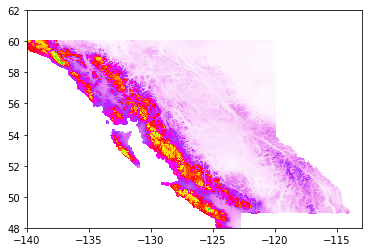

In [28]:
# plt.pcolormesh(prism_lon, prism_lat, PRISM[11, ...], cmap=plt.cm.gist_ncar_r)

In [22]:
# gridTree = KDTree_wraper(prism_lon, prism_lat)
# grid_shape = cdem_lon.shape
# dist, indexes = gridTree.query(list(zip(stn_lon, stn_lat))) # <--- variable indexes reused
# prism_indx, prism_indy = np.unravel_index(indexes, grid_shape)
# stn_clim = PRISM[:, prism_indx, prism_indy]

In [23]:
#plt.plot(stn_clim);